# インポート, csvファイルダウンロード
 (まずkaggle.jsonファイルをカレントディレクトリに置いて置く)

In [1]:
#kaggleAPIトークンファイルを設定する
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
from kaggle import KaggleApi
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import torch
from torch import nn, optim
from torchsummary import torchsummary
import zipfile
import os

#kaggleAPIをインスタンス化して認証する
api = KaggleApi()
api.authenticate()

In [2]:
#kaggleAPI経由でファイルをダウンロードして解凍する
compe_name = 'h-and-m-personalized-fashion-recommendations'
csv_fname = [f for f in api.competition_list_files(compe_name) if '.csv' in f.name]
for f in csv_fname:
  api.competition_download_file(compe_name,f.name)
  with zipfile.ZipFile(f.name+'.zip') as zf:
    zf.extractall('resources')
  os.remove(f.name+'.zip')
for i, f in enumerate(csv_fname): print(i, f)

100%|██████████| 4.26M/4.26M [00:00<00:00, 70.2MB/s]

100%|██████████| 584M/584M [00:04<00:00, 126MB/s]


100%|██████████| 50.3M/50.3M [00:00<00:00, 176MB/s]


100%|██████████| 97.9M/97.9M [00:00<00:00, 216MB/s]



0 articles.csv
1 transactions_train.csv
2 sample_submission.csv
3 customers.csv


# Dataframeの作成

In [5]:
#取引履歴, 商品情報, 顧客情報のファイルを読み込む
transactions = pd.read_csv('transactions_train.csv')
customers = pd.read_csv('customers.csv')
articles = pd.read_csv('articles.csv')

In [6]:
#取引データベースと商品データベースを結合する
articles_info = ['article_id','product_code','product_type_no','colour_group_code','garment_group_no']
db = pd.merge(transactions, articles[articles_info], on='article_id')

In [7]:
del transactions, articles, customers

In [8]:
#customerIDごとに取引データをグルーピングする
group_by_customer = db.groupby('customer_id')

In [9]:
#各顧客の購入履歴の中身
next(iter(group_by_customer))[1]

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,product_type_no,colour_group_code,garment_group_no
576487,2019-09-18,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,656719005,0.044051,2,656719,272,9,1009
1100423,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006,0.050831,2,568601,264,9,1008
1100424,2019-05-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,568601006,0.050831,2,568601,264,9,1008
4770746,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,627759010,0.030492,1,627759,262,73,1007
6262103,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,625548001,0.044051,1,625548,262,73,1007
6596034,2018-12-27,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,176209023,0.035576,1,176209,308,9,1007
13774213,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,607642008,0.012695,1,607642,259,9,1010
14587547,2019-05-02,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,697138006,0.010153,2,697138,267,51,1005
17653253,2019-07-25,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,745232001,0.021169,1,745232,275,9,1016
18345386,2020-03-21,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,795440001,0.014390,2,795440,253,9,1005


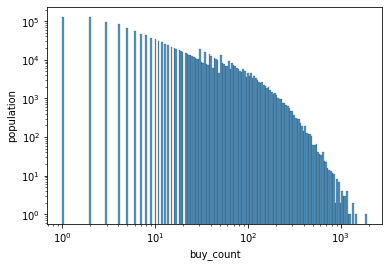

In [12]:
# 各顧客の購買商品点数
item_counts_by_customers = group_by_customer.count()['article_id']
plt.xscale('log')
plt.yscale('log')
plt.xlabel('buy_count')
plt.ylabel('population')
sns.histplot(item_counts_by_customers)
max_counts = item_counts_by_customers.max()

In [ ]:
ｙ